# Twitter Sentiment Analysis 

In this notebook, will demonstrate how to train a word embeddings layer within a recurrent neural network (e.g. LSTM) for sentiment classification. The dataset consist over 10k tweets from the 2016 U.S. Presidential debate. Each tweet is labeled as "positive", "negative" or "neutral". For simplicity, we will remove the "neutral" tweets and treat this as a binary classification problem.


In [3]:
import scipy
import itertools
import collections
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# import keras
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import  LSTM, SimpleRNN, GRU
from keras.layers.embeddings import Embedding

import matplotlib.pyplot as plt
%matplotlib inline

### Load Raw Data

In [4]:
raw=pd.read_csv("data/Sentiment.csv")

data=raw[raw['sentiment'] != 'Neutral'].reset_index(drop=True)

In [5]:
data.head()

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,...,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,2,Scott Walker,1.0000,yes,1.0,Positive,0.6333,None of the above,1.0000,NaN,...,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
1,4,No candidate mentioned,1.0000,yes,1.0,Positive,1.0000,None of the above,0.7039,NaN,...,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
2,5,Donald Trump,1.0000,yes,1.0,Positive,0.7045,None of the above,1.0000,NaN,...,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona
3,6,Ted Cruz,0.6332,yes,1.0,Positive,0.6332,None of the above,1.0000,NaN,...,NaN,228,NaN,NaN,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",NaN,2015-08-07 09:54:44 -0700,629697194283499520,NaN,Central Time (US & Canada)
4,7,No candidate mentioned,1.0000,yes,1.0,Negative,0.6761,FOX News or Moderators,1.0000,NaN,...,NaN,17,NaN,NaN,RT @warriorwoman91: I liked her and was happy ...,NaN,2015-08-07 09:54:44 -0700,629697192383672320,North Georgia,Eastern Time (US & Canada)


## Build Corpus

In [6]:
def bag_of_words(data):
    words =list(itertools.chain(*[i for i in data['text'].apply(lambda x: x.split()).values]))
    return words

def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

In [7]:
word_list = bag_of_words(data)
enc, dec = build_dataset(word_list)

### Padding

The first thing to do is to create values for our start of sentence, end of sentence, and sentence padding special tokens. We can do this by shifting the encodings to account for the '<pad>' and '<start>' tokens. We will also need to account for that in the decoders. Note: decoder doesn't need shifting, just a map of the proper number. For example, since all the words are off by 2 in the encoder, we can subtract 2 from the encoder result to get the decoder key.However, entries -1 and -2 are not in the decoder, so need to add them in.  <i>

In [8]:
for i in enc:
    enc[i] = enc[i]+2

In [9]:
enc['pad']=0
enc['<start>']=1
dec[-2]='pad'
dec[-1]='<start>'

### Encode Labels + Split Train/Test
- For each tweet, split up the tweet into bag of words
- Note, we will only be considering binary labels (positive or negative)

In [10]:
le = LabelEncoder()
data['sentiment'] = le.fit_transform(data['sentiment'])

In [18]:
n=int(np.floor(data.shape[0]*0.75))
train,test = data[0:n],data[n:]

# train/test features
x_train = list(train.iloc[:,15].apply(lambda x: [enc[i] for i in x.split()]).values)
x_test = list(test.iloc[:,15].apply(lambda x: [enc[i] for i in x.split()]).values)

# train/test labels
y_train,y_test = train.iloc[:,5],test.iloc[:,5]

### Example of original tweet

In [12]:
train.iloc[0,15]

"RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF…"

### Encoded Tweet

In [13]:
tmp = [enc[j] for j in train.iloc[0,15].split()]
print(tmp)

[2, 3340, 1242, 3341, 3, 791, 114, 37, 237, 2162, 35, 238, 7, 5570, 226, 1957, 14, 2163, 2164, 826, 9163]


### Recall that the decoder was not shifted, so will need to subtract 2 to get the correct word.

In [14]:
[dec[i-2] for i in tmp]  

['RT',
 '@ScottWalker:',
 "Didn't",
 'catch',
 'the',
 'full',
 '#GOPdebate',
 'last',
 'night.',
 'Here',
 'are',
 'some',
 'of',
 "Scott's",
 'best',
 'lines',
 'in',
 '90',
 'seconds.',
 '#Walker16',
 'http://t.co/ZSfF…']

### Explore Ideal Length of Tweets:

- How would we do this if we had really long tweet lengths?
- Plot a histogram and get an idea of where most of the data lies

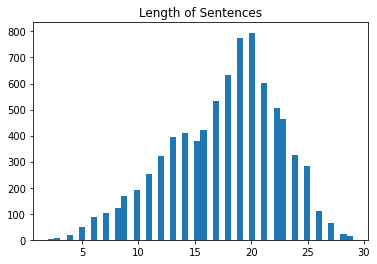

23.0
24.0
25.0
27.0


/Users/tracesmith/.pyenv/versions/3.7.3/envs/smu-nlp/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: scipy.quantile is deprecated and will be removed in SciPy 2.0.0, use numpy.quantile instead
  import sys


In [15]:
lengths = [len(i) for i in x_train]
plt.hist(lengths,bins=50)
plt.title('Length of Sentences')
plt.show()

for q in [0.85,0.90,0.95,0.99]:
    print(scipy.quantile(lengths,q))

### Pad Sequences
- Add start of sentence token and then pad sequences (29+1 start token) for a max sequence of 30.

In [22]:
x_train=[[1]+i for i in x_train]
x_test=[[1]+i for i in x_test]

x_train = sequence.pad_sequences(x_train, maxlen=30)
x_test = sequence.pad_sequences(x_test, maxlen=30)

In [31]:
x_train=np.asarray(x_train)
x_test=np.asarray(x_test)
y_train=np.asarray(y_train)
y_test=np.asarray(y_test)

### LSTM Model

- Simple LSTM Model
- Embed each word to 100 dimensions, input length is max_words (30).
- Add dropout to help w/ overfitting

In [34]:
def train(X_train,Y_train,X_test,Y_test,epochs,batch_size,embedding_vector_length,top_words,max_length):
    """ Train LSTM Model w/ Word Embeddings"""
    
    model = Sequential()
    model.add(Embedding(top_words, embedding_vector_length, input_length=max_length))
    model.add(LSTM(100,recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    print(model.summary())
    model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)
    
    return model

In [35]:
model = train(x_train,y_train,x_test,y_test,epochs=10,batch_size=64,
              embedding_vector_length=100,top_words=len(enc),max_length=30)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           2562900   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 2,643,401
Trainable params: 2,643,401
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
126/126 [==============================] - 7s 54ms/step - loss: 0.4661 - accuracy: 0.8046
Epoch 2/10
126/126 [==============================] - 7s 52ms/step - loss: 0.2122 - accuracy: 0.9160
Epoch 3/10
126/126 [==============================] - 7s 53ms/step - loss: 0.0888 - accuracy: 0.9703
Epoch 4/10
126/126 [==============================] - 7s 54ms/step